In [17]:
import requests
import pandas as pd
import time
import seaborn as sns

In [ ]:
START, END = 2020, 2024            
TEMPORAL = "daily"                  

PARAMS = [
    # precipitation & humidity
    "PRECTOTCORR","RH2M","QV2M",
    # temperature (2m)
    "T2M","T2M_MAX","T2M_MIN","T2M_RANGE",
    # wind (2m,10m), direction (10m)
    "WS2M","WS10M","WD10M",
    # radiation (shortwave, all-sky, clear-sky)
    "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN",
    # pressure
    "PS",
    # soil moisture 
    "GWETTOP","GWETROOT"
]

# Île-de-France departments (INSEE, name, lat, lon)
IDF = [
    ("75","Paris",              48.8566, 2.3522),
    ("77","Seine-et-Marne",     48.539,  2.999),
    ("78","Yvelines",           48.800,  1.900),
    ("91","Essonne",            48.530,  2.250),
    ("92","Hauts-de-Seine",     48.840,  2.240),
    ("93","Seine-Saint-Denis",  48.910,  2.450),
    ("94","Val-de-Marne",       48.770,  2.430),
    ("95","Val-d'Oise",         49.070,  2.200),
]


In [19]:
def fetch_power(lat, lon, start_year, end_year, temporal="daily"):
    """
    Return a tidy DataFrame with one row per date (daily or monthly)
    and columns for each NASA POWER variable.
    No aggregation.
    """
    if temporal not in ("daily","monthly"):
        raise ValueError("temporal must be 'daily' or 'monthly'")

    url = (
        f"https://power.larc.nasa.gov/api/temporal/{temporal}/point"
        f"?parameters={','.join(PARAMS)}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_year}&end={end_year}&format=JSON"
    )
    r = requests.get(url, timeout=90)
    if not r.ok or "application/json" not in (r.headers.get("Content-Type","").lower()):
        raise RuntimeError(f"POWER error {r.status_code}: {r.text[:200]}")

    param = r.json().get("properties",{}).get("parameter",{})
    rows = []
    for var, series in param.items():
        for key, val in series.items():
            if temporal == "daily":   
                y, m, d = int(key[:4]), int(key[4:6]), int(key[6:8])
            else:                     
                y, m, d = int(key[:4]), int(key[4:]), 1
            rows.append({"year":y,"month":m,"day":d,"var":var,"value":float(val)})
    long = pd.DataFrame(rows).sort_values(["year","month","day"])
    wide = long.pivot(index=["year","month","day"], columns="var", values="value").reset_index()
    wide["date"] = pd.to_datetime(dict(year=wide.year, month=wide.month, day=wide.day))
    cols = ["date","year","month","day"] + [c for c in wide.columns if c not in ("date","year","month","day")]
    return wide[cols]

In [ ]:

all_frames = []
for code, name, lat, lon in IDF:
    df = fetch_power(lat, lon, START, END, temporal=TEMPORAL)
    df["insee_dep"], df["department"] = code, name
    # df.to_csv(f"idf_{code}_{TEMPORAL}_power_{START}_{END}.csv", index=False)
    all_frames.append(df
)
idf_all = pd.concat(all_frames, ignore_index=True)

print(f"Done:{idf_all.shape} rows")

Done:(14616, 21) rows


In [21]:
idf_all.head()

var,date,year,month,day,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,GWETROOT,GWETTOP,PRECTOTCORR,PS,...,RH2M,T2M,T2M_MAX,T2M_MIN,T2M_RANGE,WD10M,WS10M,WS2M,insee_dep,department
0,2020-01-01,2020,1,1,1.79,5.19,0.58,0.6,0.68,101.91,...,98.50,1.95,3.86,0.25,3.61,160.8,3.07,2.06,75,Paris
1,2020-01-02,2020,1,2,2.09,4.76,0.58,0.6,0.68,101.39,...,98.45,4.84,6.70,2.63,4.07,199.1,4.20,2.84,75,Paris
2,2020-01-03,2020,1,3,2.69,5.16,0.58,0.6,1.01,101.30,...,94.04,6.97,11.43,1.89,9.54,245.7,6.39,4.41,75,Paris
3,2020-01-04,2020,1,4,4.69,5.51,0.58,0.6,0.18,102.34,...,94.54,3.88,8.65,0.15,8.50,297.1,3.43,2.08,75,Paris
4,2020-01-05,2020,1,5,3.75,5.69,0.58,0.6,0.11,102.39,...,92.34,4.10,8.27,-0.92,9.19,207.4,1.75,0.99,75,Paris


<Axes: xlabel='var'>

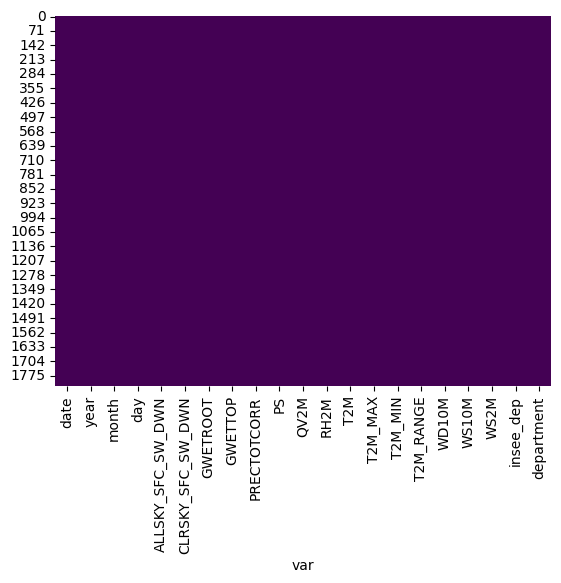

In [22]:
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [23]:
idf_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               14616 non-null  datetime64[ns]
 1   year               14616 non-null  int64         
 2   month              14616 non-null  int64         
 3   day                14616 non-null  int64         
 4   ALLSKY_SFC_SW_DWN  14616 non-null  float64       
 5   CLRSKY_SFC_SW_DWN  14616 non-null  float64       
 6   GWETROOT           14616 non-null  float64       
 7   GWETTOP            14616 non-null  float64       
 8   PRECTOTCORR        14616 non-null  float64       
 9   PS                 14616 non-null  float64       
 10  QV2M               14616 non-null  float64       
 11  RH2M               14616 non-null  float64       
 12  T2M                14616 non-null  float64       
 13  T2M_MAX            14616 non-null  float64       
 14  T2M_MI

In [24]:
idf_all.isnull().sum()

var
date                 0
year                 0
month                0
day                  0
ALLSKY_SFC_SW_DWN    0
CLRSKY_SFC_SW_DWN    0
GWETROOT             0
GWETTOP              0
PRECTOTCORR          0
PS                   0
QV2M                 0
RH2M                 0
T2M                  0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
WD10M                0
WS10M                0
WS2M                 0
insee_dep            0
department           0
dtype: int64

In [25]:
idf_all.to_csv(f"idf_weather_{TEMPORAL}_power_{START}_{END}.csv", index=False)
